# alpha Cen B analysis

These calculations are featured in Section 4.2 and Figures 4, 9, 14, 15, 16, 17, and 21 of Dodson-Robinson, Ramirez Delgado, Harrell, Haley (2022). 

### Set up python environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from matplotlib.gridspec import GridSpec
import sys
sys.path.insert(0, '/Users/sdr/NWelch/src/') # Change the directory to wherever the NWelch source code resides on your system
import TimeSeries
import Bivariate as Bi

plt.rcParams.update({"font.size":16, "axes.labelsize":16, "font.family":"sans-serif", "font.sans-serif":"Arial"})

### Load the <a href="https://ui.adsabs.harvard.edu/abs/2012Natur.491..207D/abstract">Dumusque et al. (2012)</a> HARPS dataset

In [2]:
mjd, rv, erv, bis, fwhm, rhk = np.loadtxt('Dumusque2012_aCenB_Rv.txt', unpack=True, usecols=[0,1,3,4,5,7])

### Subtract off the RV signature of binary motion

Here we follow <a href="https://ui.adsabs.harvard.edu/abs/2016ApJ...818...34E/abstract">Endl et al. (2016)</a> and use a 2nd-order polynomial to model the binary motion.

In [3]:
binary_motion = np.poly1d(np.polyfit(mjd, rv, 2, w=1/erv))
rv_d = rv - binary_motion(mjd)

### Create a <tt>TimeSeries</tt> objects for each observable

I always start my analyses with quick plots of the observed data, timestep histogram, and Lomb-Scargle-like periodogram ("like" because we are using a non-uniform FFT, not the actual Scargle algorithm). This functionality is contained in the <tt>TimeSeries</tt> class.

Note: you could just create <tt>Bivariate</tt> objects straight away and then access the <tt>TimeSeries</tt> functions through <tt>Bivariate.x_series</tt> and <tt>Bivariate.y_series</tt>, but I prefer to keep my univarite and bivariate calculations separate.

In [4]:
rv_ts = TimeSeries.TimeSeries(mjd, rv_d)
rhk_ts = TimeSeries.TimeSeries(mjd, rhk, display_frequency_info=False)
fwhm_ts = TimeSeries.TimeSeries(mjd, fwhm, display_frequency_info=False)
bis_ts = TimeSeries.TimeSeries(mjd, bis, display_frequency_info=False)

Nyquist frequency from mean dt: 0.18609
Nyquist frequency from 10% trimmed mean dt: 0.90580
Nyquist frequency from 20% trimmed mean dt: 1.05915
Nyquist frequency from median dt: 3.08605
Rayleigh resolution: 0.00081


### Plot the RV time series and the timestep distribution

Later in the notebook we will plot the log R'HK time series. The timestep distribution covers four orders of magnitude. I sometimes see $\Delta t$ distributions that span more than six orders of magnitude.

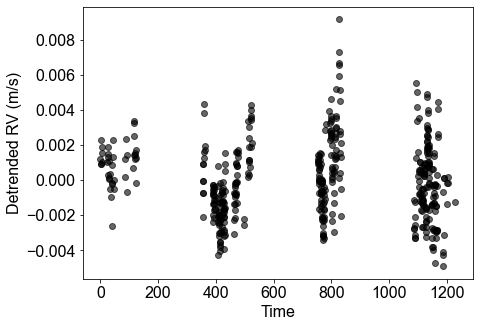

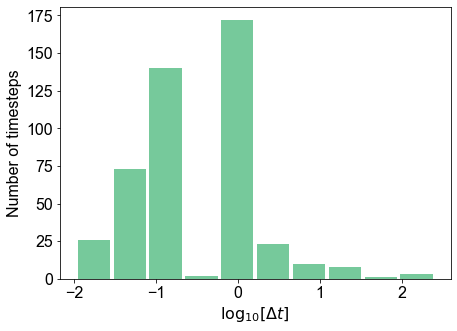

In [5]:
rv_ts.scatterplot(ylabel='Detrended RV (m/s)')
rv_ts.dthist()

### Make frequency grids for our <tt>TimeSeries</tt> objects

The Nyquist-like frequency I selected is roughly equivalent to setting <tt>nyquist_factor=2</tt> in <tt>astropy.timeseries.LombScargle</tt>.

In [6]:
rv_ts.frequency_grid(0.4, oversample=6)
rhk_ts.frequency_grid(0.4, oversample=6)
fwhm_ts.frequency_grid(0.4, oversample=6)
bis_ts.frequency_grid(0.4, oversample=6)

### Lomb-Scargle-like periodograms WITHOUT detrending

By default, <tt>NWelch</tt> subtracts a linear trend from the data before calculating a periodogram or power spectrum estimate. You can turn off the detrending by setting <tt>trend=False</tt>. I recommend detrending your data, but here I wanted to see how much low-frequency signal got removed by detrending, so I calculated the non-detrended version for comparison.

In [7]:
rv_ts.pow_FT(N_bootstrap=1000, trend=False)
rhk_ts.pow_FT(N_bootstrap=1000, trend=False)
fwhm_ts.pow_FT(N_bootstrap=1000, trend=False)
bis_ts.pow_FT(N_bootstrap=1000, trend=False)

Iteration 0
Iteration 500
Iteration 0
Iteration 500
Iteration 0
Iteration 500
Iteration 0
Iteration 500


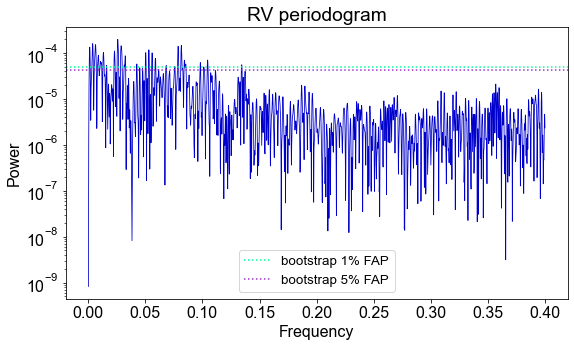

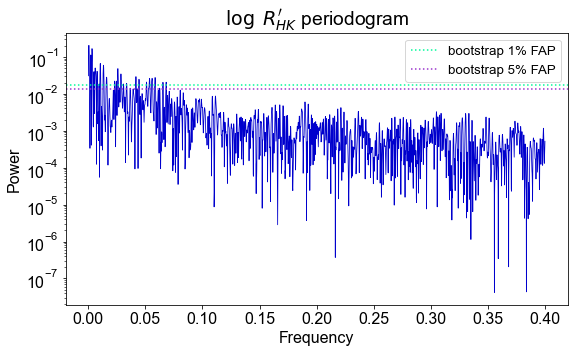

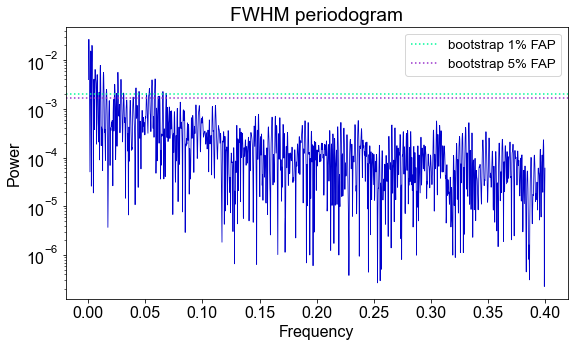

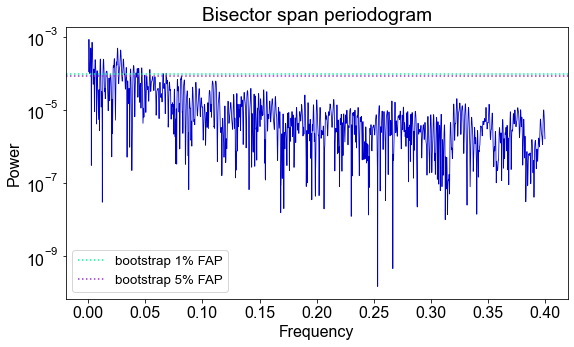

In [8]:
rv_ts.powplot(title='RV periodogram')
rhk_ts.powplot(title=r"$\log \; R^{\prime}_{HK}$ periodogram")
fwhm_ts.powplot(title='FWHM periodogram')
bis_ts.powplot(title='Bisector span periodogram')

### Calculate actual Lomb-Scargle periodograms using <tt>astropy.timeseries.LombScargle</tt>, plus false-alarm levels

<tt>NWelch</tt> periodograms are power spectral density (psd) normalized using Parseval's theorem, so we set <tt>normalization='psd'</tt>, to get the equivalent normalization from <tt>astropy</tt>. We will plot the <tt>astropy</tt> periodograms further down in this notebook.

In [9]:
nf = 0.2 / rv_ts.Nyq_meandt # This is a Nyquist factor that we will use later
faps = [0.05, 0.01]

rv_ls = LombScargle(mjd, rv_d, normalization='psd')
rhk_ls = LombScargle(mjd, rhk, normalization='psd')
fw_ls = LombScargle(mjd, fwhm, normalization='psd')
bis_ls = LombScargle(mjd, bis, normalization='psd')

rv_fals = rv_ls.false_alarm_level(faps, method='bootstrap')
rhk_fals = rhk_ls.false_alarm_level(faps, method='bootstrap')
fw_fals = fw_ls.false_alarm_level(faps, method='bootstrap')
bis_fals = bis_ls.false_alarm_level(faps, method='bootstrap')

### Use NWelch to calculate Lomb-Scargle-like periodogram with linear detrending

In [11]:
rv_ts.pow_FT(N_bootstrap=1000)
rhk_ts.pow_FT(N_bootstrap=1000)
fwhm_ts.pow_FT(N_bootstrap=1000)
bis_ts.pow_FT( N_bootstrap=1000)

Iteration 0
Iteration 500
Iteration 0
Iteration 500
Iteration 0
Iteration 500
Iteration 0
Iteration 500


Comparing with periodograms from the non-detrended data, we can see how much power has been taken out of the lowest-frequency bins. This is good for two reasons: (1) power at frequencies below the Rayleigh limit can leak into higher frequencies, and (2) power at low frequencies can bias the bootstrap false alarm thresholds. A red noise model can also help with (2).

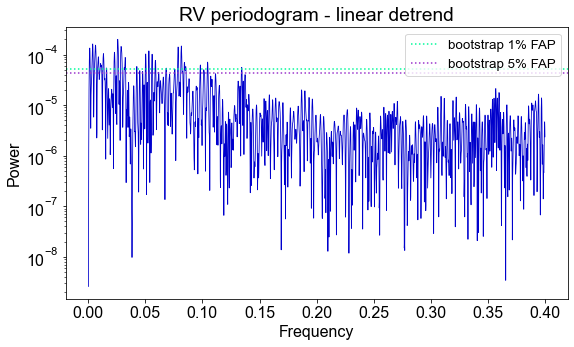

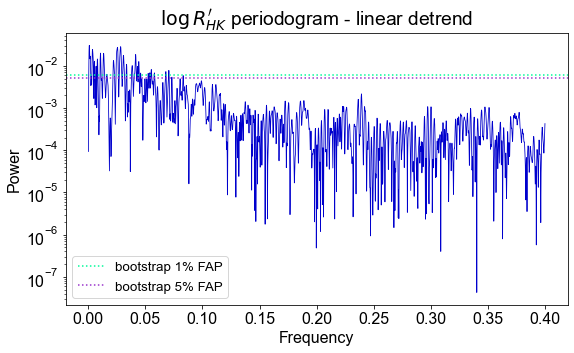

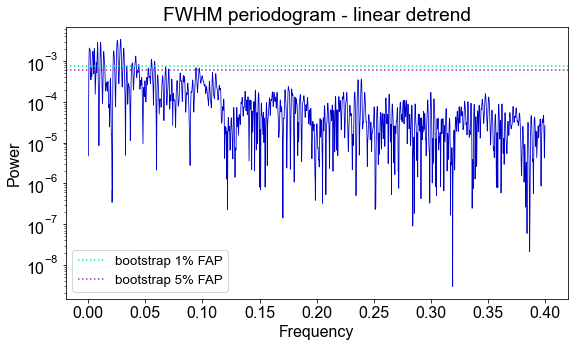

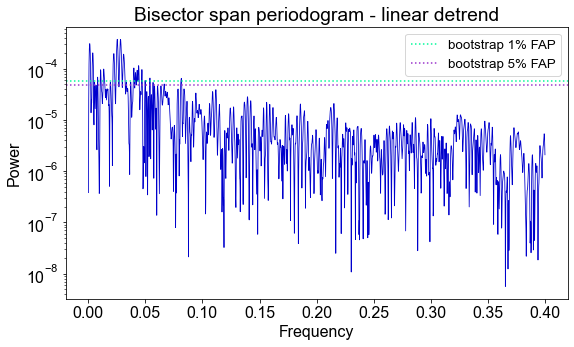

In [12]:
rv_ts.powplot(title='RV periodogram - linear detrend')
rhk_ts.powplot(title=r"$\log R^{\prime}_{HK}$ periodogram - linear detrend")
fwhm_ts.powplot(title='FWHM periodogram - linear detrend')
bis_ts.powplot(title='Bisector span periodogram - linear detrend')

### Save the Lomb-Scargle-like RV periodogram

We don't really need to; this is just to demonstrate the software functionality

In [13]:
rv_ts.save_standard('RV_periodogram_detrend_linear.csv')

### Examine the Lomb-Scargle spectral window

This spectral window is plotted nicely in Figure 9 of the accompanying paper. 'None' in the title means no taper was applied (i.e. the boxcar taper was retained).

Half bandwidth: 0.003250
Single-window results not saved


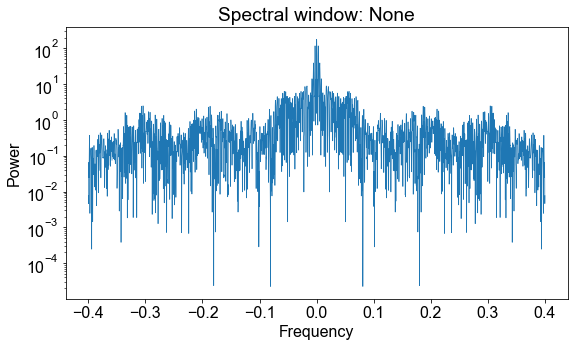

In [14]:
rv_ts.spectral_window()

### Construct the segments to be used in Welch's algorithm

See Section 3.4 of the accompanying paper.

In [15]:
seg1 = np.where(rv_ts.t < 600)[0]
seg2 = np.where((rv_ts.t > 650) & (rv_ts.t < 900))[0]
seg3 = np.where(rv_ts.t > 1000)[0]
print(seg1[0], seg1[-1])
print(seg2[0], seg2[-1])
print(seg3[0], seg3[-1])

0 184
185 304
305 458


### Use a 2-d numpy array to specify custom segments

The first argument in <tt>Bivariate.segment_data()</tt> is either an integer specifying the number of 50% overlapping segments OR a 2-d numpy array giving the indices of the first and (last+1) data point of each segment. Here, segment 1 covers data points 0-184, segment 2 covers points 185-304, and segment 3 covers points 305-458. Sorry about the annoying syntax but it matches the <tt>range()</tt> function.

In [16]:
segs = np.array([[0,185], [185,305], [305,459]])

### Nice plot showing the segmented log R'HK data

This is Figure 4 of the paper.

Text(0.5, 1.0, '$\\alpha$ Cen B, Dumusque et al. (2012)')

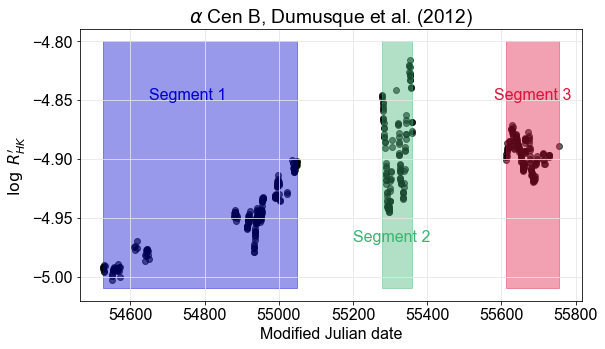

In [17]:
colors = ['mediumblue', 'mediumseagreen', 'crimson']

plt.figure(figsize=(9,5))
plt.scatter(mjd, rhk, color='k', edgecolor='k', alpha=0.6)
for i in [0,1,2]:
    seg = range(segs[i,0], segs[i,1])
    plt.fill_between(mjd[seg], -5.01*np.ones(len(seg)), -4.8*np.ones(len(seg)), color=colors[i], alpha=0.4)
plt.text(54650, -4.85, 'Segment 1', color=colors[0])
plt.text(55200, -4.97, 'Segment 2', color=colors[1])
plt.text(55580, -4.85, 'Segment 3', color=colors[2])
plt.grid(color='0.9')

plt.xlabel('Modified Julian date')
plt.ylabel(r"$\log \; R^{\prime}_{HK}$")
plt.title(r"$\alpha$ Cen B, Dumusque et al. (2012)")

### Start the coherence analysis: create the bivariate objects

From 4 observables, we will calculate (4 choose 2) = 6 coherences. The first argument to the class constructor is the array of observation times, the second is x_t, and the third is y_t. The class constructor creates two <tt>TimeSeries</tt> objects, <tt>x_series</tt> and <tt>y_series</tt>. You can access all the <tt>TimeSeries</tt> variables and methods from within the <tt>Bivariate</tt> object: for example, <tt>rv_rhk.x_series.pow_FT()</tt> is the same as <tt>rv_ts.pow_FT()</tt> from cell 11. But you could accidentally overwrite your bivariate analyses by using the code this way, which is why I create separate <tt>TimeSeries</tt> objects for all my univariate calculations. At some point I might add an overwrite warning.

In [18]:
rv_rhk = Bi.Bivariate(mjd, rv, rhk)
rv_fwhm = Bi.Bivariate(mjd, rv, fwhm)
rv_bis = Bi.Bivariate(mjd, rv, bis)
rhk_fwhm = Bi.Bivariate(mjd, rhk, fwhm)
rhk_bis = Bi.Bivariate(mjd, rhk, bis)
fwhm_bis = Bi.Bivariate(mjd, fwhm, bis)

Nyquist frequency from mean dt: 0.18609
Nyquist frequency from 10% trimmed mean dt: 0.90580
Nyquist frequency from 20% trimmed mean dt: 1.05915
Nyquist frequency from median dt: 3.08605
Rayleigh resolution: 0.00081
Nyquist frequency from mean dt: 0.18609
Nyquist frequency from 10% trimmed mean dt: 0.90580
Nyquist frequency from 20% trimmed mean dt: 1.05915
Nyquist frequency from median dt: 3.08605
Rayleigh resolution: 0.00081
Nyquist frequency from mean dt: 0.18609
Nyquist frequency from 10% trimmed mean dt: 0.90580
Nyquist frequency from 20% trimmed mean dt: 1.05915
Nyquist frequency from median dt: 3.08605
Rayleigh resolution: 0.00081
Nyquist frequency from mean dt: 0.18609
Nyquist frequency from 10% trimmed mean dt: 0.90580
Nyquist frequency from 20% trimmed mean dt: 1.05915
Nyquist frequency from median dt: 3.08605
Rayleigh resolution: 0.00081
Nyquist frequency from mean dt: 0.18609
Nyquist frequency from 10% trimmed mean dt: 0.90580
Nyquist frequency from 20% trimmed mean dt: 1.05

### Segment the data using the scheme we already plotted

Same Nyquist-like frequency as in the periodogram calculations.

In [19]:
rv_rhk.segment_data(segs, 0.4, oversample=5)
rv_fwhm.segment_data(segs, 0.4, oversample=5)
rv_bis.segment_data(segs, 0.4, oversample=5)
rhk_fwhm.segment_data(segs, 0.4, oversample=5)
rhk_bis.segment_data(segs, 0.4, oversample=5)
fwhm_bis.segment_data(segs, 0.4, oversample=5)

Number of segments: 3
Segment start and end points: [[  0 185]
 [185 305]
 [305 459]]
Effective number of segments: 3.000000
Frequency grid spacing: 0.000382
Minimum 6-dB bandwidth: 0.002311
Mean 6-dB bandwidth, resolution limit: 0.007666
Best achievable Rayleigh resolution: 0.001910
Number of segments: 3
Segment start and end points: [[  0 185]
 [185 305]
 [305 459]]
Effective number of segments: 3.000000
Frequency grid spacing: 0.000382
Minimum 6-dB bandwidth: 0.002311
Mean 6-dB bandwidth, resolution limit: 0.007666
Best achievable Rayleigh resolution: 0.001910
Number of segments: 3
Segment start and end points: [[  0 185]
 [185 305]
 [305 459]]
Effective number of segments: 3.000000
Frequency grid spacing: 0.000382
Minimum 6-dB bandwidth: 0.002311
Mean 6-dB bandwidth, resolution limit: 0.007666
Best achievable Rayleigh resolution: 0.001910
Number of segments: 3
Segment start and end points: [[  0 185]
 [185 305]
 [305 459]]
Effective number of segments: 3.000000
Frequency grid spaci

### Calculate the magnitude-squared coherences, then the bootstrap false alarm levels

These two steps are separate for magnitude-squared coherence. If you only want to look at the analytical false alarm levels, you can skip the bootstrap step, which is the most computationally intensive part of this analysis.

By default, the software will subtract a linear trend from <em>each</em> Welch's segment. If you want don't want to detrend, you can set <tt>trend=False</tt>, but I recommend linear detrending. You can also subtract a quadratic trend from each segment by setting <tt>trend_type='quadratic'</tt>. This is often done on <em>entire</em> start-to-finish RV time series, but we haven't robustly tested it with Welch's method. Use at your own risk.

In [20]:
rv_rhk.Welch_coherence_powspec()
rv_fwhm.Welch_coherence_powspec()
rv_bis.Welch_coherence_powspec()
rhk_fwhm.Welch_coherence_powspec()
rhk_bis.Welch_coherence_powspec()
fwhm_bis.Welch_coherence_powspec()

In [21]:
rv_rhk.Welch_coherence_powspec_bootstrap()
rv_fwhm.Welch_coherence_powspec_bootstrap()
rv_bis.Welch_coherence_powspec_bootstrap()
rhk_fwhm.Welch_coherence_powspec_bootstrap()
rhk_bis.Welch_coherence_powspec_bootstrap()
fwhm_bis.Welch_coherence_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500

Mean number of false-alarm threshold crossings per Rayleigh resolution from bootstrap simulations:
5% FAP: 0.243
1% FAP: 0.081
0.1% FAP: 0.018

Number of false-alarm threshold crossings per Rayleigh resolution from actual data:
5% FAP: 0.081 crossings =  0.0500 %ile
1% FAP: 0.019 crossings =  0.7700 %ile
0.1% FAP: 0.010 crossings =  0.0500 %ile

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500

Mean number of false-alarm threshold crossings per Rayleig

#### After you've done expensive bootstraping on your coherences and Welch's power spectra, you definitely want to save the results

In [22]:
rv_rhk.save_results("aCenB_D12_rv_rhk_coherence_detrend_linear.csv")
rv_fwhm.save_results("aCenB_D12_rv_fwhm_coherence_detrend_linear.csv")
rv_bis.save_results("aCenB_D12_rv_bis_coherence_detrend_linear.csv")
rhk_fwhm.save_results("aCenB_D12_rhk_fwhm_coherence_detrend_linear.csv")
rhk_bis.save_results("aCenB_D12_rhk_bis_coherence_detrend_linear.csv")
fwhm_bis.save_results("aCenB_D12_fwhm_bis_coherence_detrend_linear.csv")

### Estimate the rotation period

Rotation is the strongest signal in the data, so we find the rotation frequency just by identifying the maximum in each Welch's power spectrum. The log R'HK power spectrum is contained in <tt>rhk_fwhm.x_series.Welch_pow</tt> or <tt>rhk_bis.x_series.Welch_pow</tt>, the FWHM power spectrum is contained in <tt>rhk_fwhm.y_series.Welch_pow</tt> or <tt>rv_fwhm.y_series.Welch_pow</tt>, etc.

At some point I might add the option of making a multivariate dataset rather than a bivariate one so that each set of Fourier coefficients only has to be computed once. I haven't done it because lots of spectroscopic datasets have NaN values for some observables, so you have to segment differently for different magnitude-squared coherence pairs.

In [23]:
frot_fwhm = rhk_fwhm.pow_coh_grid[np.argmax(rhk_fwhm.y_series.Welch_pow)]
print('Rotation period (FWHM, days):', 1/frot_fwhm)

frot_bis = rhk_bis.pow_coh_grid[np.argmax(rhk_bis.y_series.Welch_pow)]
print('Rotation period (BIS, days):', 1/frot_bis)

frot_rhk = rhk_bis.pow_coh_grid[np.argmax(rhk_bis.x_series.Welch_pow)]
print('Rotation period (RHK, days):', 1/frot_rhk)

frot_ave = np.mean([frot_rhk, frot_bis, frot_fwhm])
print('Rotation period (averaged):', 1/frot_ave)

Rotation period (FWHM, days): 35.8219178082192
Rotation period (BIS, days): 39.02985074626868
Rotation period (RHK, days): 38.455882352941174
Rotation period (averaged): 37.71634615384617


### Quick plots of the Welch's power spectrum estimates

From top to bottom: RV, log R'HK, FWHM, BIS. By default, <tt>Welch_pow_plot()</tt> plots the power spectrum of <tt>x_series</tt>. You can plot the Welch's power spectrum of <tt>y_series</tt> by setting <tt>x_or_y='y'</tt>. Here I added a vertical line at the rotation frequency using the <tt>vlines</tt> keyword, which takes a list. Use the <tt>lw</tt> keyword to set the line width. You can remove the bootstrap false alarm thresholds from the plot by setting <tt>show_boot_thresholds=False</tt>. If the y-axis range comes out ugly, like in the RV power spectrum, you can follow up the call to <tt>Welch_pow_plot()</tt> with <tt>plt.ylim()</tt> or <tt>ax.set_ylim()</tt>. 

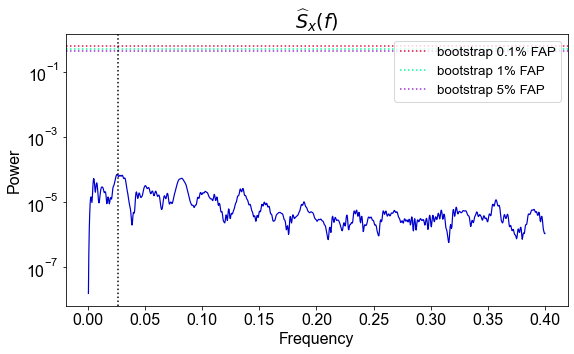

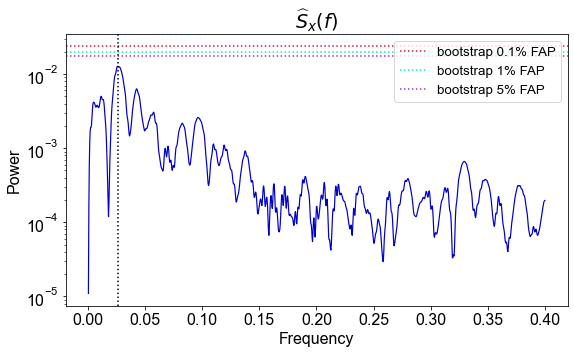

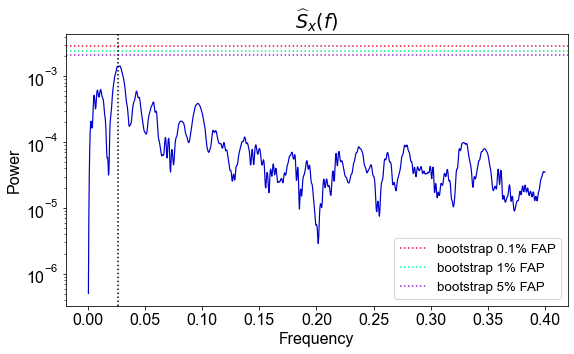

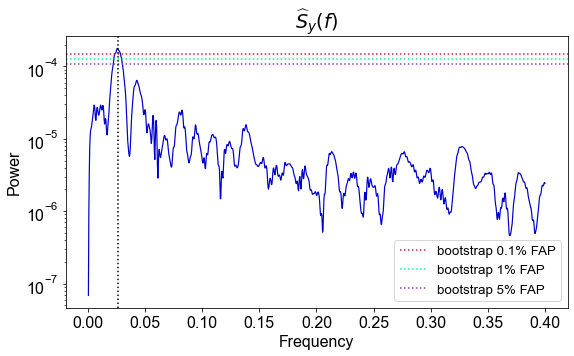

In [24]:
# RV power spectrum
rv_rhk.Welch_pow_plot(vlines=[frot_ave], lw=1.2)

# log R'HK power spectrum
rhk_fwhm.Welch_pow_plot(vlines=[frot_ave], lw=1.2)

# FWHM power spectrum
fwhm_bis.Welch_pow_plot(vlines=[frot_ave], lw=1.2)

# BIS power spectrum
rv_bis.Welch_pow_plot(x_or_y='y', vlines=[frot_ave], lw=1.2)

### Plot coherences between RV and each activity indicator

By default <tt>coh_plot()</tt> shows the canonical magnitude-squared coherence scale of 0-1. Set <tt>transformed=True</tt> to plot z(f) (Equation 15 of the paper). The transformed coherence is better for examining highly significant signals with false alarm probability < 0.01.

The default behavior is to show the bootstrap false alarm thresholds, but not the theoretical ones. You can switch it up by setting <tt>show_theoretical_thresholds=True</tt> and/or <tt>show_boot_thresholds=False</tt>.

Here you see how truly frequency-dependent the bootstrap false alarm thresholds are: Although the low-frequency coherences are high, they don't hit the 1% threshold.

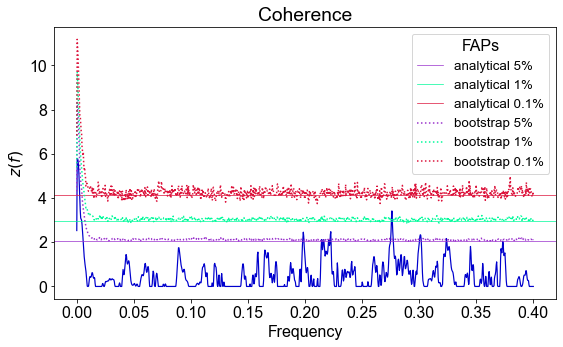

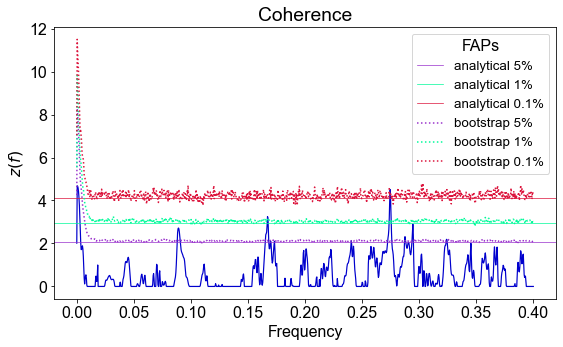

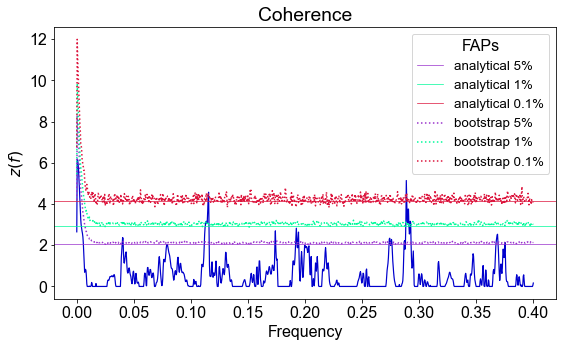

In [25]:
rv_rhk.coh_plot(show_theoretical_thresholds=True, transformed=True, lw=1.2)
rv_fwhm.coh_plot(show_theoretical_thresholds=True, transformed=True, lw=1.2)
rv_bis.coh_plot(show_theoretical_thresholds=True, transformed=True, lw=1.2)

#### These two plots of RV-BIS and RV-FWHM coherence are featured in the cell above; here I use the <tt>vlines</tt> keyword to add vertical lines marking some frequencies of high coherence.

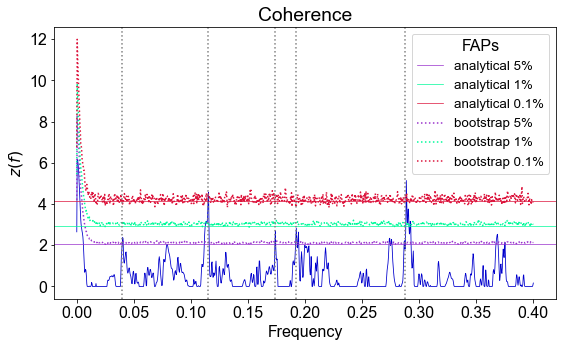

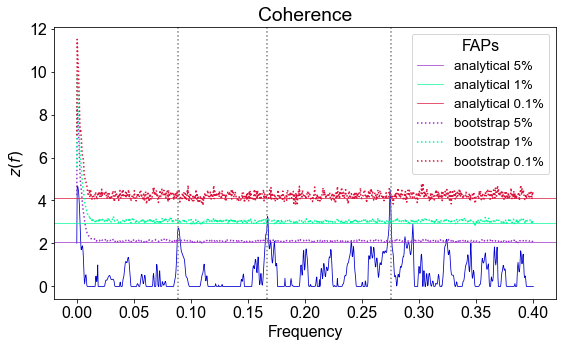

In [26]:
vlines_bis = [0.04, 0.115, 0.174, 0.192, 0.288]
rv_bis.coh_plot(show_theoretical_thresholds=True, transformed=True, vlines=vlines_bis)

vlines_fw = [0.089, 0.167, 0.275]
rv_fwhm.coh_plot(show_theoretical_thresholds=True, transformed=True, vlines=vlines_fw)

### Quick plots of coherences between the activity indicators

Top to bottom: log R'HK-FWHM, log R'HK-BIS, FWHM-BIS. Possible to-do: outer right legends.

Notice the very high coherences at the rotation frequency.

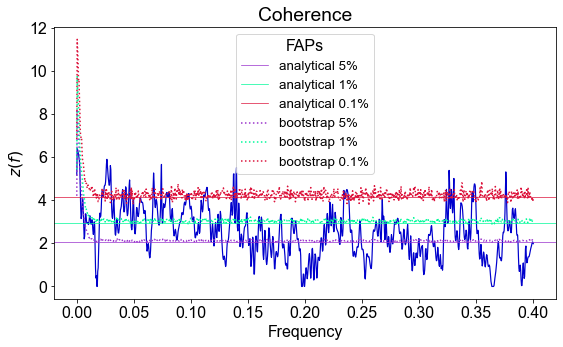

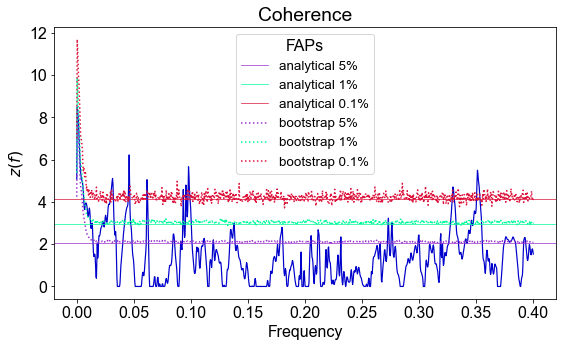

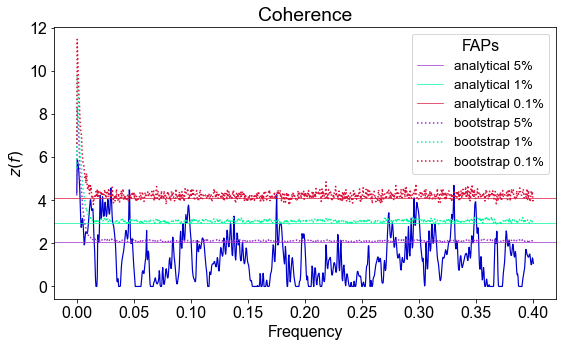

In [27]:
rhk_fwhm.coh_plot(show_theoretical_thresholds=True, transformed=True, lw=1.2)
rhk_bis.coh_plot(show_theoretical_thresholds=True, transformed=True, lw=1.2)
fwhm_bis.coh_plot(show_theoretical_thresholds=True, transformed=True, lw=1.2)

### Examine the Welch's spectral window

I know I said to keep the bivariate and univariate calculations separate, but the spectral window is the same for both series' power spectra plus the coherence calculation, so it's safe to access a <tt>TimeSeries</tt> method to do this. 

Half bandwidth: 0.005354


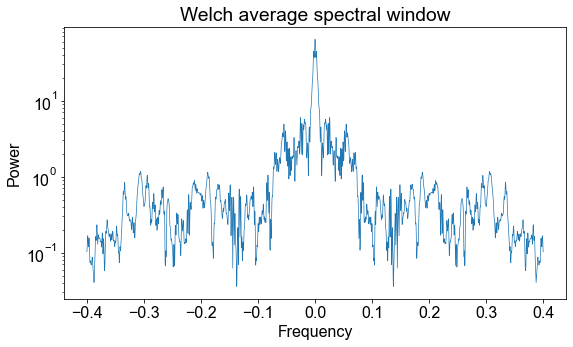

In [29]:
rhk_fwhm.x_series.spectral_window_Welch(outfile='Welch_ave_rectangular_window.txt')

### Compare Welch and Lomb-Scargle spectral windows

Text(0.5, 1.0, '$\\alpha$ Cen B, Dumusque et al. (2012)')

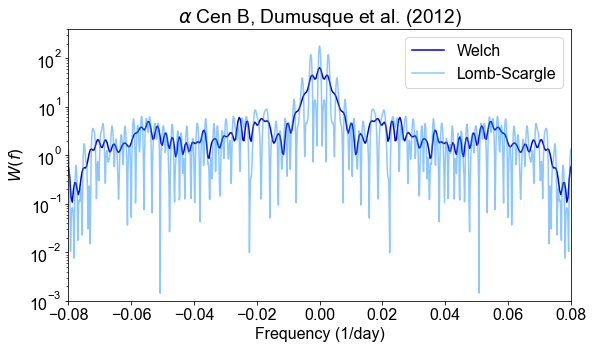

In [32]:
plt.figure(figsize=(9,5))
plt.semilogy(rhk_fwhm.x_series.Welch_fgrid, rhk_fwhm.x_series.Welch_window_function, 
         color='mediumblue', label='Welch')
plt.semilogy(rv_ts.fgrid, rv_ts.window_function, color='dodgerblue', alpha=0.5, 
         label='Lomb-Scargle')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$W(f)$")
plt.xlim([-0.08, 0.08])
plt.ylim([1e-3, 400])
plt.legend(loc='best')
plt.title(r"$\alpha$ Cen B, Dumusque et al. (2012)")

### Check to see if any of the RV-activity indicator coherence line up with rotation harmonics

Not really.

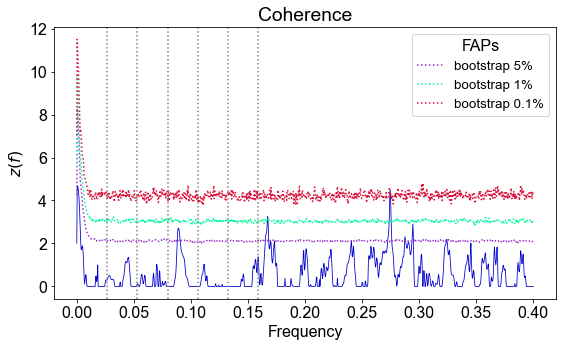

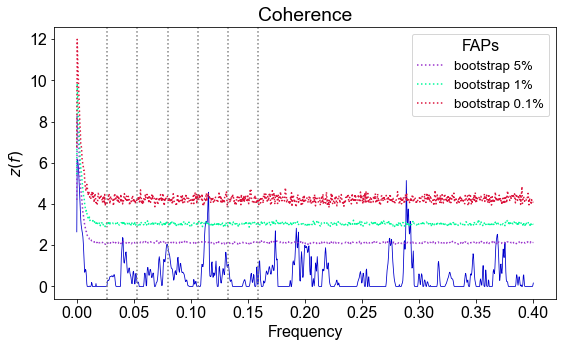

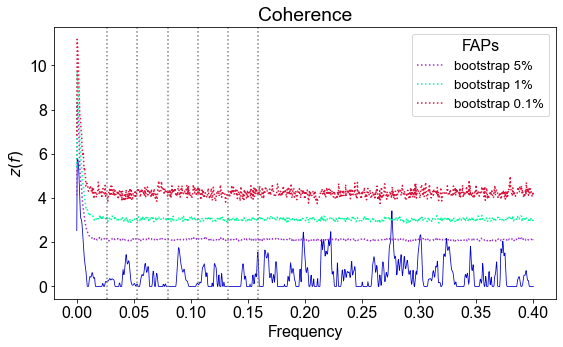

In [33]:
harmonics = [frot_ave*i for i in range(1,7)]

rv_fwhm.coh_plot(transformed=True, vlines=harmonics)
rv_bis.coh_plot(transformed=True, vlines=harmonics)
rv_rhk.coh_plot(transformed=True, vlines=harmonics)

### Figure 15 of paper: y(x) scatter plots of each (4 choose 2) observables

Text(0.5, 0, 'BIS (km/s)')

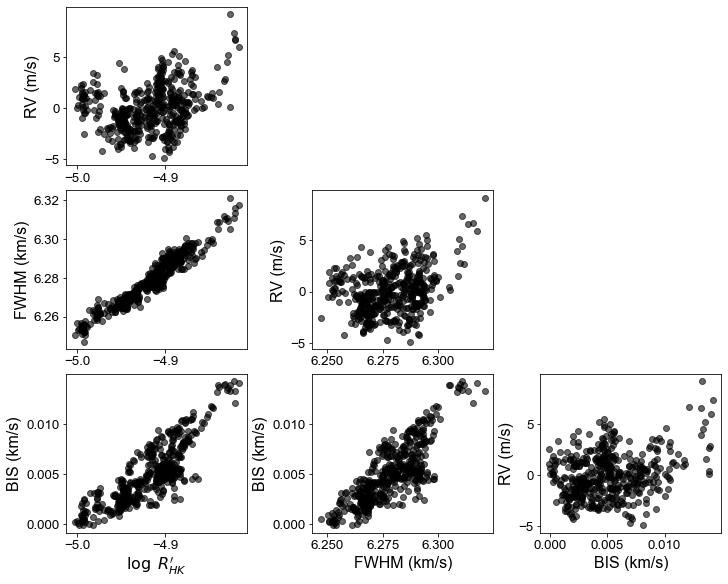

In [34]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
gs = GridSpec(3, 3, figure=fig, hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
ax2 = fig.add_subplot(gs[2,0], sharex=ax1)
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,1], sharex=ax3)
ax5 = fig.add_subplot(gs[2,2])

for ax in ([ax0, ax1, ax2, ax3, ax4, ax5]):
    ax.tick_params(labelsize='small')

ax0.scatter(rhk, rv_d*1000, color='k', edgecolor='k', alpha=0.6)
ax0.set_ylabel('RV (m/s)')
ax1.scatter(rhk, fwhm, color='k', edgecolor='k', alpha=0.6)
ax1.set_ylabel('FWHM (km/s)')
ax2.scatter(rhk, bis, color='k', edgecolor='k', alpha=0.6)
ax2.set_ylabel('BIS (km/s)')
ax2.set_xlabel(r"$\log \; R^{\prime}_{HK}$")

ax3.scatter(fwhm, rv_d*1000, color='k', edgecolor='k', alpha=0.6)
ax3.set_ylabel('RV (m/s)')
ax4.scatter(fwhm, bis, color='k', edgecolor='k', alpha=0.6)
ax4.set_ylabel('BIS (km/s)')
ax4.set_xlabel('FWHM (km/s)')

ax5.scatter(bis, rv_d*1000, color='k', edgecolor='k', alpha=0.6)
ax5.set_ylabel('RV (m/s)')
ax5.set_xlabel('BIS (km/s)')

### See if any of the coherent RV-BIS or RV-FWHM signals can be attributed to the Welch window function

We could get window function peaks masquerading as coherent signals from an imperfectly removed zero-frequency term. But it doesn't look like that's what's happening.

Text(0, 0.5, '$W(f)$')

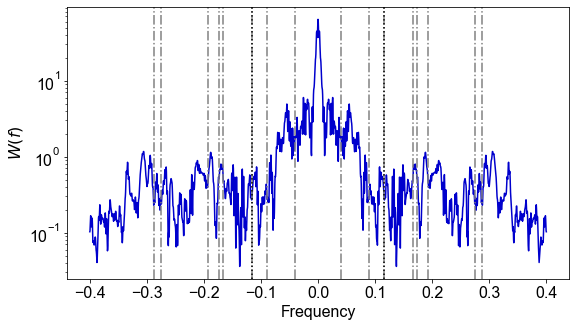

In [35]:
plt.figure(figsize=(9,5))
plt.semilogy(rhk_fwhm.x_series.Welch_fgrid, rhk_fwhm.x_series.Welch_window_function, 
         color='mediumblue')
for l in vlines_bis+vlines_fw:
    plt.axvline(l, color='gray', ls='-.')
    plt.axvline(-l, color='gray', ls='-.')
plt.axvline(vlines_bis[1], color='k', ls=':')
plt.axvline(-vlines_bis[1], color='k', ls=':')
plt.xlabel('Frequency')
plt.ylabel(r"$W(f)$")

### Nice plots of RV-activity coherences

This is Figure 17 of the paper.

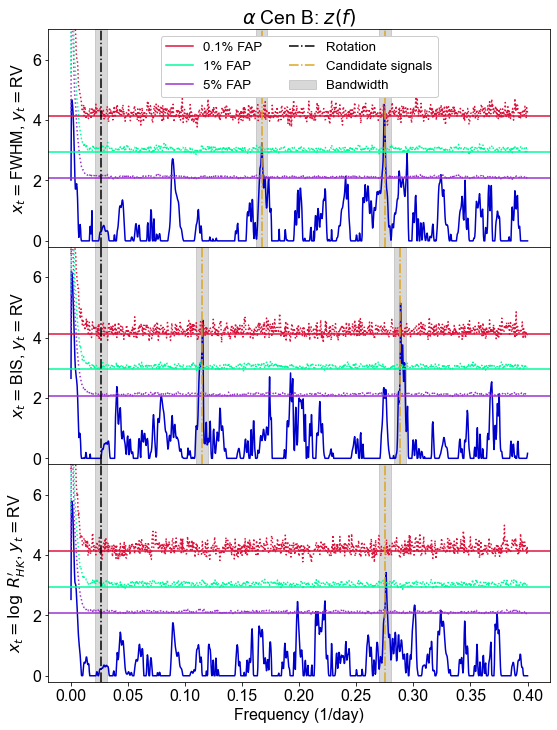

In [36]:
bw = 0.00513

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,12))

ax1.plot(rv_fwhm.pow_coh_grid, rv_fwhm.coh_transformed, color='mediumblue')
ax1.plot(rv_fwhm.pow_coh_grid, rv_fwhm.coh_transformed_boot_5, color='darkorchid', ls=':')
ax1.plot(rv_fwhm.pow_coh_grid, rv_fwhm.coh_transformed_boot_1, color='mediumspringgreen', ls=':')
ax1.plot(rv_fwhm.pow_coh_grid, rv_fwhm.coh_transformed_boot_01, color='crimson', ls=':')
ax1.axhline(Bi.ztrans(rv_fwhm.coh_prob_01, rv_fwhm.Nseg_eff), color='crimson', label='0.1% FAP')
ax1.axhline(Bi.ztrans(rv_fwhm.coh_prob_1, rv_fwhm.Nseg_eff), color='mediumspringgreen', label='1% FAP')
ax1.axhline(Bi.ztrans(rv_fwhm.coh_prob_5, rv_fwhm.Nseg_eff), color='darkorchid', label='5% FAP')
ax1.axvline(frot_ave, ls='-.', color='k', label='Rotation')
ax1.axvline(0.167, color='goldenrod', ls='-.', label='Candidate signals')
ax1.fill_between([frot_ave-bw,frot_ave+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3, label='Bandwidth')
ax1.fill_between([0.167-bw,0.167+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3)
ax1.axvline(0.275, color='goldenrod', ls='-.')
ax1.fill_between([0.275-bw,0.275+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3)
ax1.legend(loc='upper center', fontsize='small', ncol=2, framealpha=1)
ax1.set_ylabel(r"$x_t =$FWHM, $y_t =$RV")
ax1.set_ylim([-0.2,7])
ax1.set_title(r"$\alpha$ Cen B: $z(f)$")

ax2.plot(rv_bis.pow_coh_grid, rv_bis.coh_transformed, color='mediumblue')
ax2.plot(rv_bis.pow_coh_grid, rv_bis.coh_transformed_boot_5, color='darkorchid', ls=':')
ax2.plot(rv_bis.pow_coh_grid, rv_bis.coh_transformed_boot_1, color='mediumspringgreen', ls=':')
ax2.plot(rv_bis.pow_coh_grid, rv_bis.coh_transformed_boot_01, color='crimson', ls=':')
ax2.axhline(Bi.ztrans(rv_bis.coh_prob_01, rv_bis.Nseg_eff), color='crimson', label='0.1% FAP')
ax2.axhline(Bi.ztrans(rv_bis.coh_prob_1, rv_bis.Nseg_eff), color='mediumspringgreen', label='1% FAP')
ax2.axhline(Bi.ztrans(rv_bis.coh_prob_5, rv_bis.Nseg_eff), color='darkorchid', label='5% FAP')
ax2.axvline(frot_ave, ls='-.', color='k')
ax2.axvline(0.115, color='goldenrod', ls='-.')
ax2.fill_between([0.115-bw,0.115+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3)
ax2.axvline(0.288, color='goldenrod', ls='-.')
ax2.fill_between([0.288-bw,0.288+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3)
ax2.fill_between([frot_ave-bw,frot_ave+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3, label='Bandwidth')
ax2.set_ylabel(r"$x_t =$BIS, $y_t =$RV")
ax2.set_ylim([-0.2,7])

ax3.plot(rv_rhk.pow_coh_grid, rv_rhk.coh_transformed, color='mediumblue')
ax3.plot(rv_rhk.pow_coh_grid, rv_rhk.coh_transformed_boot_5, color='darkorchid', ls=':')
ax3.plot(rv_rhk.pow_coh_grid, rv_rhk.coh_transformed_boot_1, color='mediumspringgreen', ls=':')
ax3.plot(rv_rhk.pow_coh_grid, rv_rhk.coh_transformed_boot_01, color='crimson', ls=':')
ax3.axhline(Bi.ztrans(rv_rhk.coh_prob_01, rv_rhk.Nseg_eff), color='crimson', label='0.1% FAP')
ax3.axhline(Bi.ztrans(rv_rhk.coh_prob_1, rv_rhk.Nseg_eff), color='mediumspringgreen', label='1% FAP')
ax3.axhline(Bi.ztrans(rv_rhk.coh_prob_5, rv_rhk.Nseg_eff), color='darkorchid', label='5% FAP')
ax3.axvline(frot_ave, ls='-.', color='k')
ax3.fill_between([frot_ave-bw,frot_ave+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3)
ax3.axvline(0.275, color='goldenrod', ls='-.', label='Candidate signals')
ax3.fill_between([0.275-bw,0.275+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.3)
ax3.set_ylabel(r"$x_t = \log \; R^{\prime}_{HK}$, $y_t =$RV")
ax3.set_ylim([-0.2,7])
ax3.set_xlabel('Frequency (1/day)')

plt.subplots_adjust(hspace=0)

I printed out frequencies at which RV-FWHM coherence exceeded the 5% false alarm threshold in an attempt to figure out what the physical origin of the stellar signals could be. I didn't figure it out; I just guessed. I hope a stellar physicist will look into the origins of stellar signals that are not obviously rotation harmonics, but have periods too long for granulation. Beating differential rotation signal? Giant cells? What? 

In [37]:
print(rv_fwhm.pow_coh_grid[np.where(rv_fwhm.coh_transformed > rv_fwhm.coh_transformed_boot_5)[0]])

[0.08833652 0.08871893 0.08910134 0.08948375 0.08986616 0.09024857
 0.09063098 0.16558317 0.16596558 0.16634799 0.1667304  0.16711281
 0.16749522 0.16787763 0.17323136 0.24053537 0.27265774 0.27304015
 0.27342256 0.27380497 0.27418738 0.27456979 0.2749522  0.27533461
 0.27571702 0.28718929 0.2875717  0.28795411 0.29407266 0.29445507
 0.29483748 0.32390057 0.32428298]


### Compare NWelch and astropy Lomb-Scargle-(like) periodograms

This is Figure 21. The invalid value warning comes from including zero in the frequency grid.

Iteration 0
Iteration 500


/Users/sdr/opt/anaconda3/lib/python3.8/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)


Text(0.5, 0, 'Frequency (1/day)')

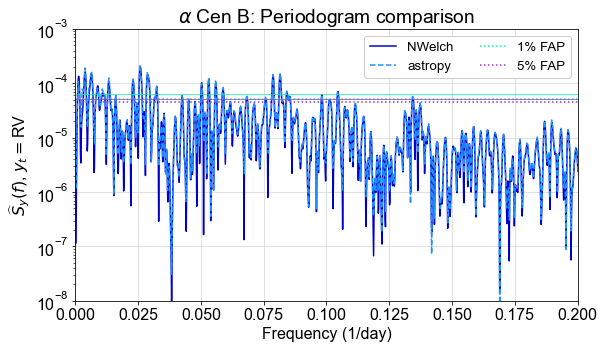

In [40]:
rv_ts.pow_FT(N_bootstrap=1000, trend=False) # Redo the periodogram with no trend subtraction
powrv = rv_ls.power(rhk_fwhm.pow_coh_grid)

fig, ax1 = plt.subplots(1, 1, figsize=(9,5))
ax1.semilogy(rv_ts.powfgrid[2:], rv_ts.power[2:], color='mediumblue', label='NWelch')
ax4.semilogy(rhk_fwhm.pow_coh_grid, powrv, color='dodgerblue', alpha=0.5, label='Lomb-Scargle')

ax1.semilogy(rhk_fwhm.pow_coh_grid, powrv, color='dodgerblue', ls='--', label='astropy')
ax1.axhline(rv_ts.false_alarm_1, color='mediumspringgreen', ls=':', label='1% FAP')
ax1.axhline(rv_fals[1], color='mediumspringgreen', lw=0.7)
ax1.axhline(rv_fals[0], color='darkorchid', lw=0.7)
ax1.axhline(rv_ts.false_alarm_5, color='darkorchid', ls=':', label='5% FAP')
ax1.set_title(r"$\alpha$ Cen B: Periodogram comparison")
ax1.set_ylabel(r"$\widehat{S}_y(f)$, $y_t =$RV")
ax1.legend(loc='upper right', fontsize='small', ncol=2, facecolor='white', framealpha=1)
ax1.grid(color='0.85')
ax1.set_ylim([1e-8,1e-3])
ax1.set_xlim([0,0.2])
ax1.set_xlabel('Frequency (1/day)')

### Calculate the Welch's power spectrum of the non-detrended RV data

You can see the strong low-frequency contribution that detrending suppresses.

In [41]:
rv_ts.segment_data(segs, 0.4, oversample=5)
rv_ts.Welch_powspec(trend=False)
rv_ts.Welch_powspec_bootstrap(N_Welch_bootstrap=1000)

Number of segments: 3
Segment start and end points: [[  0 185]
 [185 305]
 [305 459]]
Effective number of segments: 3.000000
Frequency grid spacing: 0.000382
Minimum 6-dB bandwidth: 0.002311
Mean 6-dB bandwidth, resolution limit: 0.007666
Best achievable Rayleigh resolution: 0.001910
Iteration 0
Iteration 500


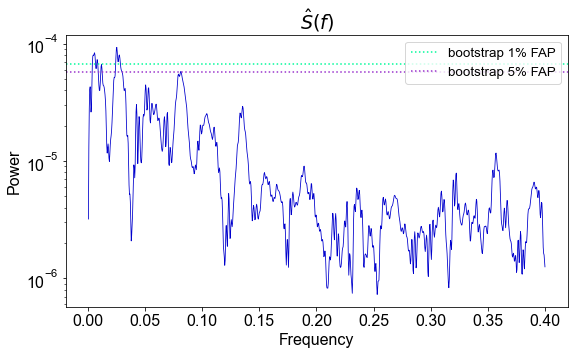

In [42]:
rv_ts.powplot(Welch=True)

### Three Siegel's tests

Top: Welch's power spectrum of non-detrended RV data; Middle: Lomb-Scargle-like peridogram of detrended RV data; Bottom: Welch's power spectrum of detrended RV data.

You can see from various plots above that detrending makes a difference in where the false alarm thresholds land, but all three power spectrum estimates show evidence for periodicity according to Siegel's test. Bootstrap false alarm thresholds can be pretty flaky (see section 3.7 of the paper), so it's good to have another method of testing for significant signals.

In [43]:
rv_ts.Siegel_test(Welch=True)

T statistic: 0.01885
T threshold for rejecting white noise hypothesis at 5% level: 0.00675
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [44]:
rv_ts.Siegel_test()

T statistic: 0.08777
T threshold for rejecting white noise hypothesis at 5% level: 0.00318
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [45]:
rv_rhk.x_series.Siegel_test(Welch=True)

T statistic: 0.01451
T threshold for rejecting white noise hypothesis at 5% level: 0.00675
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


#### <tt>Siegel_Welch()</tt> will apply Siegel's test to both Welch's power spectrum estimates in a <tt>Bivariate</tt> object

In [47]:
rv_rhk.Siegel_Welch()
fwhm_bis.Siegel_Welch()

Siegel's test on Gxx:
T statistic: 0.01451
T threshold for rejecting white noise hypothesis at 5% level: 0.00675
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
Siegel's test on Gyy:
T statistic: 0.12010
T threshold for rejecting white noise hypothesis at 5% level: 0.00675
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
Siegel's test on Gxx:
T statistic: 0.09487
T threshold for rejecting white noise hypothesis at 5% level: 0.00675
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
Siegel's test on Gyy:
T statistic: 0.18542
T threshold for rejecting white noise hypothesis at 5% level: 0.00675
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [48]:
print(frot_ave)

0.02651370299553855


### Nice plot of coherences between activity indicators

This is Figure 16 of the paper.

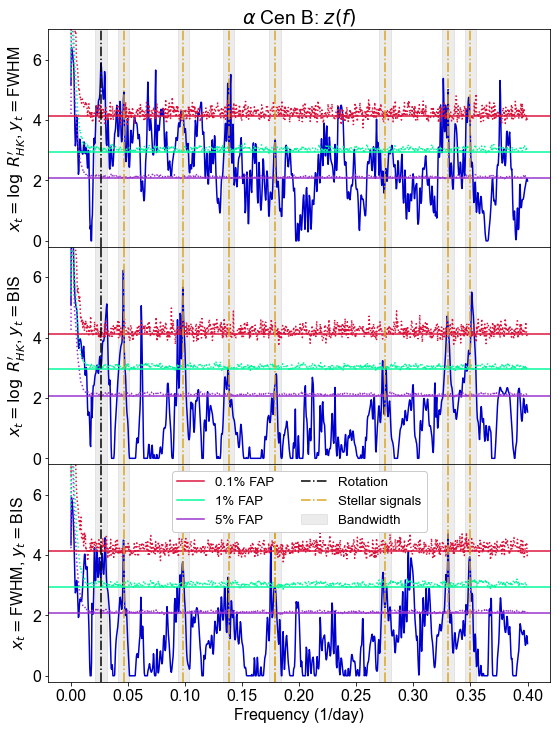

In [49]:
shared = [0.0460, 0.0985, 0.138, 0.179, 0.275, 0.33, 0.35]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,12))

ax1.plot(rhk_fwhm.pow_coh_grid, rhk_fwhm.coh_transformed, color='mediumblue')
ax1.plot(rhk_fwhm.pow_coh_grid, rhk_fwhm.coh_transformed_boot_5, color='darkorchid', ls=':')
ax1.plot(rhk_fwhm.pow_coh_grid, rhk_fwhm.coh_transformed_boot_1, color='mediumspringgreen', ls=':')
ax1.plot(rhk_fwhm.pow_coh_grid, rhk_fwhm.coh_transformed_boot_01, color='crimson', ls=':')
ax1.axhline(Bi.ztrans(rhk_fwhm.coh_prob_01, rhk_fwhm.Nseg_eff), color='crimson', label='0.1% FAP')
ax1.axhline(Bi.ztrans(rhk_fwhm.coh_prob_1, rhk_fwhm.Nseg_eff), color='mediumspringgreen', label='1% FAP')
ax1.axhline(Bi.ztrans(rhk_fwhm.coh_prob_5, rhk_fwhm.Nseg_eff), color='darkorchid', label='5% FAP')
ax1.axvline(frot_ave, ls='-.', color='k', label='Rotation')
ax1.fill_between([frot_ave-bw,frot_ave+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.15)
for f in shared:
    ax1.axvline(f, ls='-.', color='goldenrod')
    ax1.fill_between([f-bw,f+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.15)
ax1.set_ylabel(r"$x_t = \log \; R^{\prime}_{HK}$, $y_t =$FWHM")
ax1.set_ylim([-0.2,7])
ax1.set_title(r"$\alpha$ Cen B: $z(f)$")

ax2.plot(rhk_bis.pow_coh_grid, rhk_bis.coh_transformed, color='mediumblue')
ax2.plot(rhk_bis.pow_coh_grid, rhk_bis.coh_transformed_boot_5, color='darkorchid', ls=':')
ax2.plot(rhk_bis.pow_coh_grid, rhk_bis.coh_transformed_boot_1, color='mediumspringgreen', ls=':')
ax2.plot(rhk_bis.pow_coh_grid, rhk_bis.coh_transformed_boot_01, color='crimson', ls=':')
ax2.axhline(Bi.ztrans(rhk_bis.coh_prob_01, rhk_bis.Nseg_eff), color='crimson', label='0.1% FAP')
ax2.axhline(Bi.ztrans(rhk_bis.coh_prob_1, rhk_bis.Nseg_eff), color='mediumspringgreen', label='1% FAP')
ax2.axhline(Bi.ztrans(rhk_bis.coh_prob_5, rhk_bis.Nseg_eff), color='darkorchid', label='5% FAP')
ax2.axvline(frot_ave, ls='-.', color='k')
ax2.fill_between([frot_ave-bw,frot_ave+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.15)
for f in shared:
    ax2.axvline(f, ls='-.', color='goldenrod')
    ax2.fill_between([f-bw,f+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.15)
ax2.set_ylabel(r"$x_t = \log \; R^{\prime}_{HK}$, $y_t =$BIS")
ax2.set_ylim([-0.2,7])

ax3.plot(fwhm_bis.pow_coh_grid, fwhm_bis.coh_transformed, color='mediumblue')
ax3.plot(fwhm_bis.pow_coh_grid, fwhm_bis.coh_transformed_boot_5, color='darkorchid', ls=':')
ax3.plot(fwhm_bis.pow_coh_grid, fwhm_bis.coh_transformed_boot_1, color='mediumspringgreen', ls=':')
ax3.plot(fwhm_bis.pow_coh_grid, fwhm_bis.coh_transformed_boot_01, color='crimson', ls=':')
ax3.axhline(Bi.ztrans(fwhm_bis.coh_prob_01, fwhm_bis.Nseg_eff), color='crimson', label='0.1% FAP')
ax3.axhline(Bi.ztrans(fwhm_bis.coh_prob_1, fwhm_bis.Nseg_eff), color='mediumspringgreen', label='1% FAP')
ax3.axhline(Bi.ztrans(fwhm_bis.coh_prob_5, fwhm_bis.Nseg_eff), color='darkorchid', label='5% FAP')
ax3.axvline(frot_ave, ls='-.', color='k', label='Rotation')
ax3.fill_between([frot_ave-bw,frot_ave+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.15, label='Bandwidth')
for f in shared:
    ax3.axvline(f, ls='-.', color='goldenrod')
    ax3.fill_between([f-bw,f+bw], [-0.2,-0.2], [7,7], color='gray', alpha=0.15)
ax3.axvline(shared[3], ls='-.', color='goldenrod', label='Stellar signals')
ax3.legend(loc='upper center', fontsize='small', ncol=2, framealpha=1)
ax3.set_ylabel(r"$x_t =$FWHM, $y_t =$BIS")
ax3.set_ylim([-0.2,7])
ax3.set_xlabel('Frequency (1/day)')

plt.subplots_adjust(hspace=0)

### Nice plot of Welch's power spectra

Lomb-Scargle periodograms are plotted for comparison. This is Figure 14 of the paper.

/Users/sdr/opt/anaconda3/lib/python3.8/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)


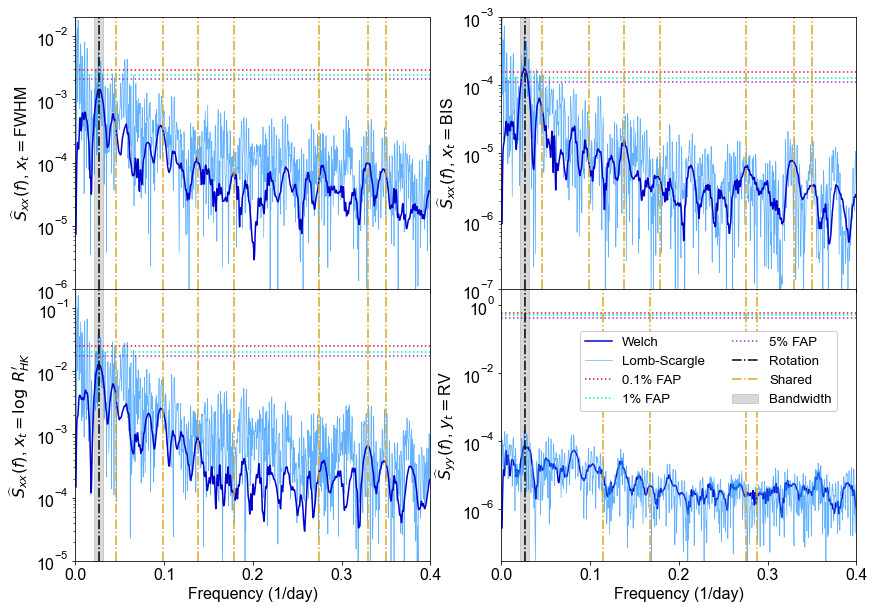

In [51]:
powfw = fw_ls.power(rhk_fwhm.pow_coh_grid) # For this dataset, all Bivariate objects have same frequency gridding
powbis = bis_ls.power(rhk_fwhm.pow_coh_grid)
powrhk = rhk_ls.power(rhk_fwhm.pow_coh_grid)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(14,10))

ax1.semilogy(rhk_fwhm.pow_coh_grid, powfw, color='dodgerblue', alpha=0.7, lw=0.7, label='Lomb-Scargle')
ax1.semilogy(rhk_fwhm.pow_coh_grid[2:], rhk_fwhm.y_series.Welch_pow[2:], color='mediumblue', label='Welch')
ax1.axhline(rhk_fwhm.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1% FAP')
ax1.axhline(rhk_fwhm.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1% FAP')
ax1.axhline(rhk_fwhm.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5% FAP')
ax1.axvline(frot_ave, color='k', ls='-.', label='Rotation')
ax1.set_ylabel(r"$\widehat{S}_{xx}(f)$, $x_t =$FWHM")
ax1.fill_between([frot_ave-bw,frot_ave+bw], [1e-6,1e-6], [2e-2, 2e-2], color='gray', alpha=0.3, label='Bandwidth')
for s in shared:
    ax1.axvline(s, ls='-.', color='goldenrod')
ax1.set_ylim([1e-6,2e-2])

ax2.semilogy(rhk_fwhm.pow_coh_grid, powbis, color='dodgerblue', alpha=0.7, lw=0.7)
ax2.semilogy(rhk_bis.pow_coh_grid[2:], rhk_bis.y_series.Welch_pow[2:], color='mediumblue')
ax2.axhline(rhk_bis.ypow_Welch_false_alarm_01, color='crimson', ls=':')
ax2.axhline(rhk_bis.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':')
ax2.axhline(rhk_bis.ypow_Welch_false_alarm_5, color='darkorchid', ls=':')
ax2.axvline(frot_ave, color='k', ls='-.')
ax2.set_ylabel(r"$\widehat{S}_{xx}(f)$, $x_t =$BIS")
for s in shared:
    ax2.axvline(s, ls='-.', color='goldenrod')
ax2.set_ylim([1e-7,1e-3])
ax2.fill_between([frot_ave-bw,frot_ave+bw], [1e-7,1e-7], [1e-3, 1e-3], color='gray', alpha=0.3)

ax3.semilogy(rhk_fwhm.pow_coh_grid, powrhk, color='dodgerblue', alpha=0.7, lw=0.7, label='Lomb-Scargle')
ax3.semilogy(rhk_bis.pow_coh_grid[2:], rhk_bis.x_series.Welch_pow[2:], color='mediumblue', label='Welch')
ax3.axhline(rhk_bis.xpow_Welch_false_alarm_01, color='crimson', ls=':')
ax3.axhline(rhk_bis.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':')
ax3.axhline(rhk_bis.xpow_Welch_false_alarm_5, color='darkorchid', ls=':')
ax3.axvline(frot_ave, color='k', ls='-.')
ax3.set_ylabel(r"$\widehat{S}_{xx}(f)$, $x_t = \log \; R^{\prime}_{HK}$")
ax3.set_xlabel("Frequency (1/day)")
ax3.set_ylim([1e-5,2e-1])
ax3.set_xlim([0,0.4])
for s in shared:
    ax3.axvline(s, ls='-.', color='goldenrod')
ax3.fill_between([frot_ave-bw,frot_ave+bw], [1e-5,1e-5], [2e-1, 2e-1], color='gray', alpha=0.3)
ax3.set_xlabel("Frequency (1/day)")

ax4.semilogy(rv_rhk.pow_coh_grid[2:], rv_rhk.x_series.Welch_pow[2:], color='mediumblue', label='Welch')
ax4.semilogy(rhk_fwhm.pow_coh_grid, powrv, color='dodgerblue', alpha=0.7, lw=0.7, label='Lomb-Scargle')
ax4.axhline(rv_rhk.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1% FAP')
ax4.axhline(rv_rhk.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1% FAP')
ax4.axhline(rv_rhk.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5% FAP')
ax4.axvline(frot_ave, color='k', ls='-.', label='Rotation')
ax4.fill_between([frot_ave-bw,frot_ave+bw], [3e-8,3e-8], [3, 3], color='gray', alpha=0.3, label='Bandwidth')
ax4.set_xlim([0,0.4])
ax4.set_ylim([3e-8,3])
ax4.axvline(0.167, ls='-.', color='goldenrod', label='Shared')
ax4.axvline(0.115, ls='-.', color='goldenrod')
ax4.axvline(0.275, ls='-.', color='goldenrod')
ax4.axvline(0.288, ls='-.', color='goldenrod')
ax4.set_ylabel(r"$\widehat{S}_{yy}(f)$, $y_t =$RV")
ax4.set_xlabel("Frequency (1/day)")
ax4.legend(loc=(0.22,0.55), fontsize='small', ncol=2, facecolor='white', framealpha=1)

plt.subplots_adjust(hspace=0)